### Modified from the ICESat-2 data tutorial

#### original authors: Scott Henderson, Anthony Arendt, David Shean, University of Washington

In [16]:
%matplotlib inline
import os
import s3fs
import xarray as xr
import h5py
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import cartopy.crs as ccrs
from mpl_toolkits.mplot3d import Axes3D

### Initial steps are disabled via `if False` to avoid accidentally running them

In [17]:
# mount S3 as if it was a file system

if False: 
    bucket = 'pangeo-data-upload-oregon'
    fs = s3fs.S3FileSystem()

# List contents of the bucket

if False:
    dataDir = 'pangeo-data-upload-oregon/icesat2/atl06'
    s3List = fs.ls(dataDir)   
    print(s3List)

# work with the first data file

if False: 
    s3File = s3List[0]
    dataFile = format(s3File.split('/')[3])

# Download an HDF5 to home directory
# If data are in your git directory: Be sure to .gitignore .h5 files so they are not pushed to GitHub.

if False:
    fs.get(s3File, dataFile)

### Using h5py to look at the dataset structure

ICESat-2 data are structured in h5 files with multiple group levels. To find what you need it helps to view these groups. 

In [18]:
dataroot = '/home/jovyan/data/icesat2/'
datafiles = os.listdir(dataroot)
source = [dataroot + df for df in datafiles]
datafile = source[0]
f = h5py.File(datafile,'r')
print(type(f), '\n\n\n')

# HDF5 behaves like a nested dictionary or if you like as a file system containing data

groups = list(f.keys())              # groups is a list of file keys; there are 10 including 6 for the icesat2 beams

print("Here is the top level directory of the HDF5 file:\n")
for g in groups: print(g)            # treated as a list of key strings: The "top level directory contents"
    
print('\n\n\n')

for g in groups:
    print('---','Group: {}'.format(g), '---')
    group = f[g]                                      # 'g' is a dictionary key. Values are a list of keys
    for d in group.keys(): print('    ', group[d])

<class 'h5py._hl.files.File'> 



Here is the top level directory of the HDF5 file:

METADATA
ancillary_data
gt1l
gt1r
gt2l
gt2r
gt3l
gt3r
orbit_info
quality_assessment




--- Group: METADATA ---
     <HDF5 group "/METADATA/AcquisitionInformation" (4 members)>
     <HDF5 group "/METADATA/DataQuality" (2 members)>
     <HDF5 group "/METADATA/DatasetIdentification" (0 members)>
     <HDF5 group "/METADATA/Extent" (0 members)>
     <HDF5 group "/METADATA/Lineage" (13 members)>
     <HDF5 group "/METADATA/ProcessStep" (4 members)>
     <HDF5 group "/METADATA/ProductSpecificationDocument" (0 members)>
     <HDF5 group "/METADATA/QADatasetIdentification" (0 members)>
     <HDF5 group "/METADATA/SeriesIdentification" (0 members)>
--- Group: ancillary_data ---
     <HDF5 dataset "atlas_sdp_gps_epoch": shape (1,), type "<f8">
     <HDF5 dataset "control": shape (1,), type "|S100000">
     <HDF5 dataset "data_end_utc": shape (1,), type "|S27">
     <HDF5 dataset "data_start_utc": shape (1,), ty

The key for ground track 3-right:
      gt3r 

The keys for gt3r:
 <KeysViewHDF5 ['land_ice_segments', 'residual_histogram', 'segment_quality']> 

That first key, being land_ice_segments:
 land_ice_segments 

the keys for land_ice_segments:
<KeysViewHDF5 ['atl06_quality_summary', 'delta_time', 'h_li', 'h_li_sigma', 'latitude', 'longitude', 'segment_id', 'sigma_geo_h', 'bias_correction', 'dem', 'fit_statistics', 'geophysical', 'ground_track']>
the first land ice height: 
 3.4028235e+38 

39873 39873 39873


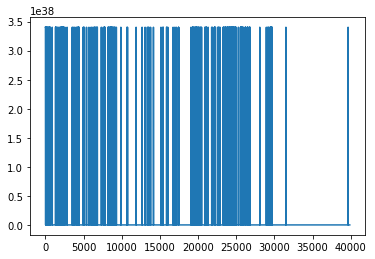

In [19]:
toplevel=f.keys()
a=list(toplevel)[7]

print('The key for ground track 3-right:')
print('     ', a, '\n')

b = f[a].keys()

print('The keys for gt3r:\n', b, '\n')

c = list(b)[0]

print('That first key, being land_ice_segments:\n', c, '\n')

print('the keys for land_ice_segments:')
print(f[a][c].keys())

d=list(f[a][c]['h_li'])[0]

print('the first land ice height: \n', d, '\n')

is_h = list(f[a][c]['h_li'])
is_lat = list(f[a][c]['latitude'])
is_lon = list(f[a][c]['longitude'])
print(len(is_h), len(is_lat), len(is_lon))
plt.plot(is_h)


In [20]:
f.close()

### Enter xarray

Let's use gt3r/land_ice_segments.


There were two files that proved defective, were deleted (both small). For the record:

* `/home/jovyan/data/icesat2/ATL06_20190130075041_05020206_001_01.h5`
* `/home/jovyan/data/icesat2/ATL06_20190207073402_06240206_001_01.h5`

In [21]:
ds = xr.open_dataset(source[125],group='/gt3r/land_ice_segments')
print(ds)

<xarray.Dataset>
Dimensions:                (delta_time: 51996)
Coordinates:
  * delta_time             (delta_time) datetime64[ns] 2019-02-11T07:23:08.574424876 ... 2019-02-11T07:25:38.591585384
    latitude               (delta_time) float64 ...
    longitude              (delta_time) float64 ...
Data variables:
    atl06_quality_summary  (delta_time) int8 ...
    h_li                   (delta_time) float32 ...
    h_li_sigma             (delta_time) float32 ...
    segment_id             (delta_time) float64 ...
    sigma_geo_h            (delta_time) float32 ...
Attributes:
    Description:  The land_ice_height group contains the primary set of deriv...
    data_rate:    Data within this group are sparse.  Data values are provide...


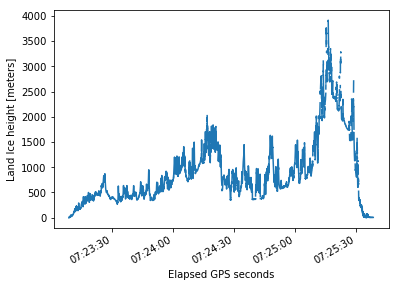

In [24]:
ds.h_li.plot()

### Convert to Pandas dataframe

In [25]:
df = ds.to_dataframe()
df.head(6)

,atl06_quality_summary,h_li,h_li_sigma,latitude,longitude,segment_id,sigma_geo_h
delta_time,,,,,,,
2019-02-11 07:23:08.574424876,0,-3.036849,0.021863,69.074334,-137.803808,617433.0,100.000977
2019-02-11 07:23:08.577251592,0,-2.944434,0.025753,69.074156,-137.803869,617434.0,0.543762
2019-02-11 07:23:08.580073932,0,-2.824141,0.029655,69.073978,-137.803930,617435.0,0.687503
2019-02-11 07:23:08.582891880,0,-2.807736,0.025909,69.073800,-137.803991,617436.0,0.670269
2019-02-11 07:23:08.585699940,0,-2.892120,0.025132,69.073622,-137.804052,617437.0,1.196414
2019-02-11 07:23:08.588499128,0,-2.946195,0.030962,69.073444,-137.804113,617438.0,0.493714


## Make a simple 3D scatter plot

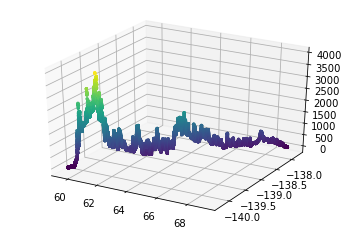

In [26]:
f = plt.figure()
ax3D = f.add_subplot(111, projection='3d')
sc = ax3D.scatter(df['latitude'], df['longitude'], df['h_li'], c=df['h_li'], marker='.')

## Convert the Pandas dataframe to a Geopandas dataframe

This mean the latitude and longitude columns are converted from just numbers into a geometry so Python knows where the data are in space.

In [27]:
df['geometry'] = list(zip(df['longitude'], df['latitude']))
df['geometry'] = df['geometry'].apply(Point)
gdf = gpd.GeoDataFrame(df)
df.head()

,atl06_quality_summary,h_li,h_li_sigma,latitude,longitude,segment_id,sigma_geo_h,geometry
delta_time,,,,,,,,
2019-02-11 07:23:08.574424876,0,-3.036849,0.021863,69.074334,-137.803808,617433.0,100.000977,POINT (-137.8038083493256 69.07433426012111)
2019-02-11 07:23:08.577251592,0,-2.944434,0.025753,69.074156,-137.803869,617434.0,0.543762,POINT (-137.8038693218038 69.0741561741153)
2019-02-11 07:23:08.580073932,0,-2.824141,0.029655,69.073978,-137.803930,617435.0,0.687503,POINT (-137.8039302643916 69.07397808680759)
2019-02-11 07:23:08.582891880,0,-2.807736,0.025909,69.073800,-137.803991,617436.0,0.670269,POINT (-137.803991175656 69.07379999820378)
2019-02-11 07:23:08.585699940,0,-2.892120,0.025132,69.073622,-137.804052,617437.0,1.196414,POINT (-137.804052130067 69.07362191148063)


### make a simple map

* get a geojson file with US state polygons
* use Cartopy to make a very simple map

In [28]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

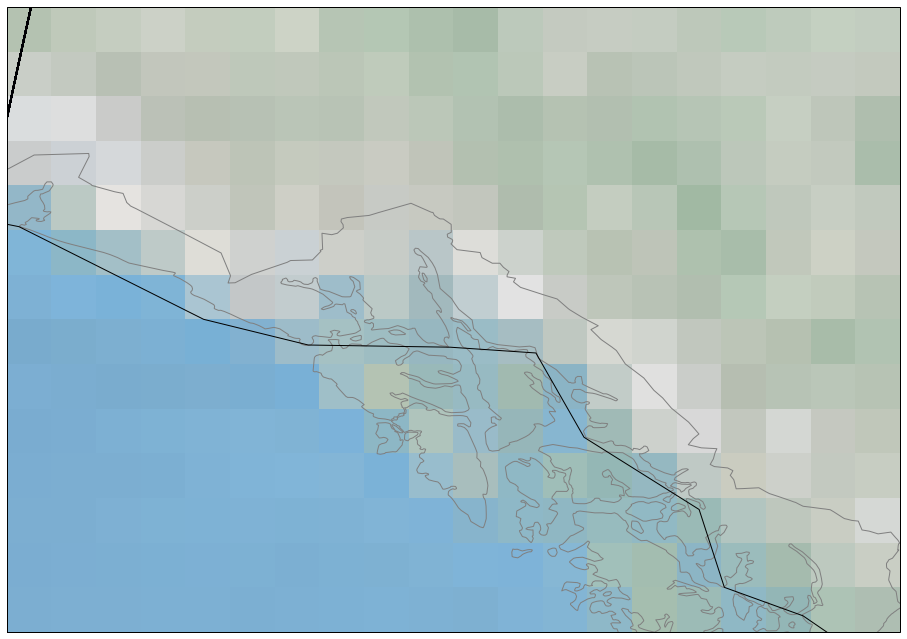

In [30]:
fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-140,-130, 55, 62])
ax.stock_img()
states_gdf.plot(ax=ax, facecolor='none', edgecolor='gray')
gdf.plot(ax=ax, column='h_li', cmap='inferno', markersize=.5)
ax.coastlines()

CPU times: user 6min 22s, sys: 3.8 s, total: 6min 26s
Wall time: 8min 3s


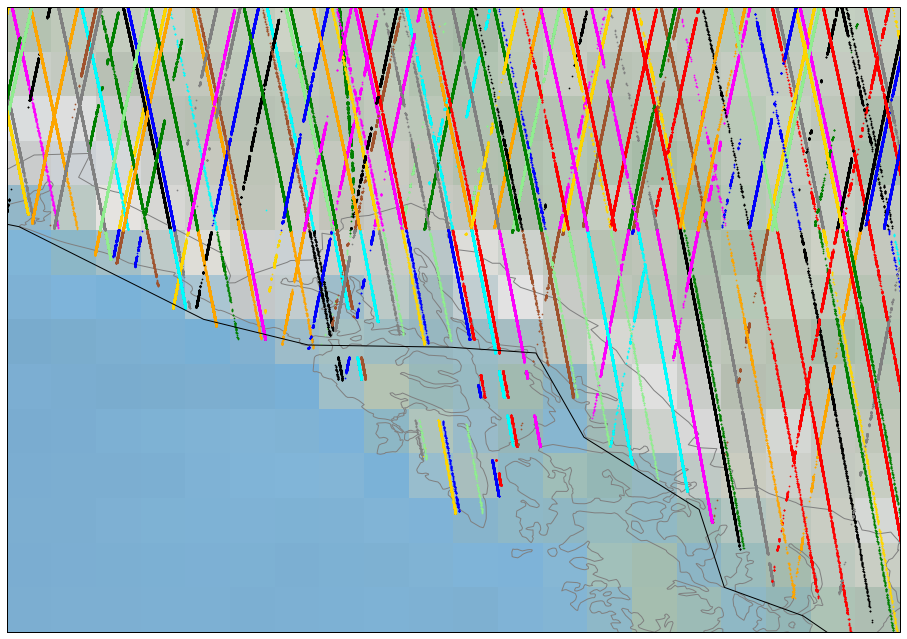

In [31]:
%%time

# create a geopandas data frame from state outlines for some added map context; particularly coastline
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-140,-130, 55, 62])
ax.stock_img()
states_gdf.plot(ax=ax, facecolor='none', edgecolor='gray')
ax.coastlines()

c=['sienna', 'gold', 'red', 'orange', 'lightgreen', 'green', 'cyan', 'blue', 'fuchsia', 'grey', 'black']
nc = len(c)

fi0 = 0
fi1 = len(source)
for i in range(fi0, fi1):
    # print(i, source[i])
    ds = xr.open_dataset(source[i],group='/gt3r/land_ice_segments')
    df = ds.to_dataframe()
    df['geometry'] = list(zip(df['longitude'], df['latitude']))
    df['geometry'] = df['geometry'].apply(Point)
    gdf = gpd.GeoDataFrame(df)
    gdf.plot(ax=ax, color=c[i%nc], markersize=.5)    # see original for column/cmap combo to color
    ds.close()


In [38]:
for i in range(30):
    ds = xr.open_dataset(source[i],group='/gt3r/land_ice_segments')
    print(ds.latitude[0:3].values, ds.latitude[-3:].values)

[59.50737823 59.5084509  59.51739125] [68.59589141 68.78973375 69.37311295]
[59.47205081 59.47185294 59.46591302] [59.45447485 57.05335567 56.96818242]
[57.07583843 57.07601806 57.07620243] [59.50356506 59.50374004 59.50392091]
[59.50242709 59.50224843 59.50206977] [55.39450809 55.39432909 55.39415009]
[56.93177353 56.93767554 56.94232621] [59.4830388  59.48321761 59.50018045]
[69.57461597 69.5744405  69.57426197] [59.5064634  59.50628044 59.50609174]
[76.57491154 76.5747332  76.57455476] [59.52943153 59.52925076 59.5290986 ]
[59.51381447 59.51684609 59.52129448] [69.05925491 69.07118404 69.07421159]
[70.07419765 70.07401961 70.07384159] [59.60594763 59.60577218 59.60468374]
[59.50205943 59.50223821 59.50241698] [69.07552763 69.07570573 69.07588444]
[59.52088012 59.54057013 59.54074959] [69.5137577  69.54650951 69.54668753]
[70.07471339 70.07453718 70.0743548 ] [59.5007223  59.50054349 59.50036468]
[59.50577529 59.50595406 59.50613285] [69.77204088 69.78348744 69.91008369]
[59.5145077 

In [40]:
if False: 
    fi0 = 0
    fi1 = len(source)
    jiftrax = []
    for i in range(fi0, fi1):
        ds = xr.open_dataset(source[i],group='/gt3r/land_ice_segments')
        if ds.latitude[0].values < 59.6 and ds.latitude[-1].values < 59.6:
            if ds.longitude[0] > -136.:
                if ds.longitude[0] < -133.5:
                    jiftrax.append(i)
    print(jiftrax)

2 /home/jovyan/data/icesat2/ATL06_20181115223845_07380102_001_01.h5
44 /home/jovyan/data/icesat2/ATL06_20181014001049_02350102_001_01.h5
51 /home/jovyan/data/icesat2/ATL06_20190116194212_02960202_001_01.h5
70 /home/jovyan/data/icesat2/ATL06_20181218210616_12410102_001_01.h5
99 /home/jovyan/data/icesat2/ATL06_20190210182651_06770202_001_01.h5
134 /home/jovyan/data/icesat2/ATL06_20181018000228_02960102_001_01.h5
143 /home/jovyan/data/icesat2/ATL06_20181109112837_06390106_001_01.h5
158 /home/jovyan/data/icesat2/ATL06_20181111224708_06770102_001_01.h5
204 /home/jovyan/data/icesat2/ATL06_20190214181831_07380202_001_01.h5
206 /home/jovyan/data/icesat2/ATL06_20181214211434_11800102_001_01.h5


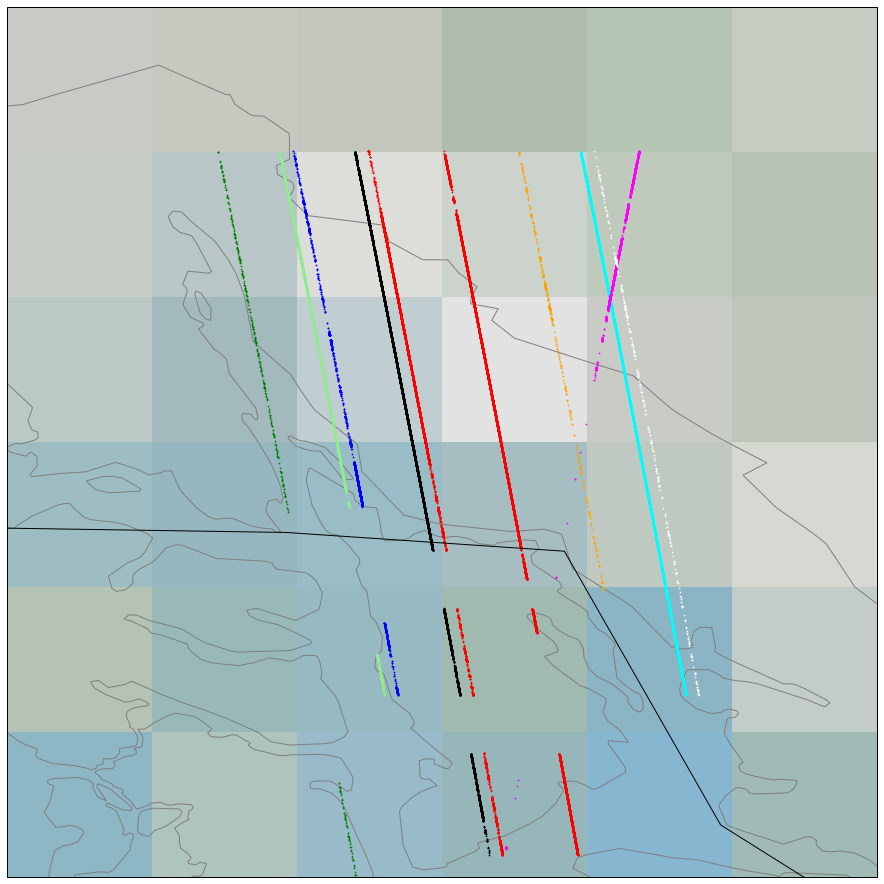

In [59]:
# all: jiftrax = [1, 2, 4, 33, 44, 51, 70, 94, 99, 117, 134, 143, 158, 161, 165, 192, 204, 206, 207, 210]
jiftrax = [2, 44, 51, 70, 99, 134, 143, 158, 204, 206]

# create a geopandas data frame from state outlines for some added map context; particularly coastline
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-136,-133, 57, 60])
ax.stock_img()
states_gdf.plot(ax=ax, facecolor='none', edgecolor='gray')
ax.coastlines()

c=['red', 'orange', 'lightgreen', 'green', 'cyan', 'blue', 'magenta', 'white', 'black']
nc = len(c)

for i in range(len(jiftrax)):
    j = jiftrax[i]
    print(j, source[j])
    ds = xr.open_dataset(source[j],group='/gt3r/land_ice_segments')
    df = ds.to_dataframe()
    df['geometry'] = list(zip(df['longitude'], df['latitude']))
    df['geometry'] = df['geometry'].apply(Point)
    gdf = gpd.GeoDataFrame(df)
    gdf.plot(ax=ax, color=c[i%nc], markersize=.5)    # see original for column/cmap combo to color
    ds.close()